<a href="https://colab.research.google.com/github/akiddd37/AI-Group-Project-Oct-25/blob/main/AIGroupProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**AI Project Oct 2025<br>**
Course: Principle of Artificial Intelligence (ISB46703)<br>
Lecturer Name: Sir Ahmad Zhafri Hariz<br>
Group Members:
<ul>
<li>Harith Akid bin Mohd Effendy (50220124004)</li>
<li>Muhammad Amirul Hakeem (52213124031)</li>
<li>Muhamad Rusydi Hakim (52213124508)</li>
</ul>

# 1. Project Overview
The goal of this project is to build an Artificial Intelligence (AI) system capable of recognizing and classifying 10 different animal species (such as tigers, bears, and eagles). We aim to compare three different deep learning models to determine which one offers the best performance in terms of accuracy and speed.

# 2. Data Preparation
We collected approximately 9,700 images using web crawling tools. The dataset is divided into three parts to ensure fair testing:
<ul>
<li>Training Set (70%): Used to teach the model.</li>
<li>Validation Set (20%): Used to tune the model during training.</li>
<li>Testing Set (10%): Used to evaluate the final performance on unseen images.</li>
</ul>
Link to dataset: https://drive.google.com/drive/folders/1XhSfpOZ2TTkH28IbFLKq1Xz5xJN-b79g?usp=sharing

# 3. Data Modelling
We are comparing three famous Convolutional Neural Network (CNN) architectures:
<ul>
<li>ResNet50</li>
<li>DenseNet121</li>
<li>MobileNetV3</li>
</ul>
By the end of this project, we will identify the best performance model, the one that provides the best balance of classification accuracy, training speed, and mAP score for our specific animal dataset.

In [ ]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/AI Oct 25

Mounted at /content/drive/
/content/drive/My Drive/AI Oct 25


In [ ]:
# import all the libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense,Flatten,BatchNormalization,Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
# Create and separate all the images into 3 separate folder
# (train, valid, test)

# 1. Setup paths
os.chdir('/content/drive/My Drive/AI Oct 25/dataset/full')

# 2. Define all the classes (Easier to manage than copy-pasting code)
classes = ['bear', 'deer', 'eagle', 'elephant', 'fox',
           'horse', 'monkey', 'owl', 'parrot', 'tiger']

# 3. Loop through each class
for class_name in classes:
    print(f"Processing {class_name}...")

    # Create directories
    os.makedirs(f'train/{class_name}', exist_ok=True)
    os.makedirs(f'valid/{class_name}', exist_ok=True)
    os.makedirs(f'test/{class_name}', exist_ok=True)

    # A. GET ALL FILES ONCE
    # This finds all files starting with the class name (e.g., "bear_01.jpg")
    all_files = glob.glob(f'{class_name}*')

    # B. SHUFFLE ONCE
    random.shuffle(all_files)

    # C. CALCULATE SPLIT POINTS
    n_total = len(all_files)
    if n_total == 0:
        print(f"⚠️ Warning: No images found for {class_name}")
        continue

    n_train = int(n_total * 0.70) # 70%
    n_valid = int(n_total * 0.20) # 20%
    # Remaining 10% goes to test

    # D. SLICE THE LIST
    train_files = all_files[:n_train]
    valid_files = all_files[n_train:n_train + n_valid]
    test_files  = all_files[n_train + n_valid:]

    # E. MOVE THE FILES
    for f in train_files:
        shutil.move(f, f'train/{class_name}')
    for f in valid_files:
        shutil.move(f, f'valid/{class_name}')
    for f in test_files:
        shutil.move(f, f'test/{class_name}')

    print(f"   -> Moved {len(train_files)} Train, {len(valid_files)} Valid, {len(test_files)} Test")

# 4. Clean up
os.chdir('../../') # Go back to original directory
print("✅ Done!")

In [ ]:
# The main purpose of this block of code is to copy all the data inside dataset
# in the Google Drive to the local runtime directory.
# It can increases the speed of the training time.

# 1. Define source (Drive) and destination (Colab Local)
source_dir = '/content/drive/My Drive/AI Oct 25/dataset/full'
local_dir = '/content/fast_dataset'

# 2. Check if already copied to save time
if not os.path.exists(local_dir):
    print("🚀 Copying data to local runtime.")
    shutil.copytree(source_dir, local_dir)
    print("✅ Copy complete!")
else:
    print("✅ Data already on local disk.")

# 3. UPDATE YOUR PATHS to point to the new local folder
train_path = os.path.join(local_dir, 'train')
valid_path = os.path.join(local_dir, 'valid')
test_path  = os.path.join(local_dir, 'test')



🚀 Copying data to local runtime.
✅ Copy complete!


In [ ]:
# Plot Image function

def plotImages(images_arr, labels_arr=None):
    # Limit to 10 images max so the plot doesn't get too tiny
    count = min(len(images_arr), 10)

    fig, axes = plt.subplots(1, count, figsize=(20, 20))
    axes = axes.flatten()

    for i in range(count):
        img = images_arr[i]
        ax = axes[i]

        # --- FIX COLORS FOR DISPLAY ---
        img_display = (img - img.min()) / (img.max() - img.min())

        ax.imshow(img_display)
        ax.axis('off')

        # Optional: Show the class label if provided
        if labels_arr is not None:
            # Check which index is '1' (e.g., [0, 1, 0, 0...])
            class_index = np.argmax(labels_arr[i])
            ax.set_title(f"Class: {class_index}")

    plt.tight_layout()
    plt.show()

## MobileNetv3

In [ ]:
# --- MOBILENET V3 SETUP ---
print("🚀 Starting MobileNetV3 Training...")

# 1. Generators (Note: using mobilenet_v3.preprocess_input)
train_gen_mobile = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=32)

valid_gen_mobile = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=32)

test_gen_mobile = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224, 224), batch_size=32, shuffle=False)

# 2. Define the Model
base_mobile = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_mobile.trainable = False

model_mobilenet = tf.keras.Sequential([
    base_mobile,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_mobilenet.summary()

# 3. Compile
model_mobilenet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(curve='PR', name='mAP')]
)

# 4. Train (Saving history to a unique variable)
history_mobilenet = model_mobilenet.fit(
    x=train_gen_mobile,
    validation_data=valid_gen_mobile,
    epochs=50,
    verbose=2
)

🚀 Starting MobileNetV3 Training...
Found 6971 images belonging to 10 classes.
Found 1988 images belonging to 10 classes.
Found 1006 images belonging to 10 classes.
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 944,890 (3.60 MB)

 Trainable params: 5,770 (22.54 KB)

 Non-trainable params: 939,120 (3.58 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
218/218 - 47s - 218ms/step - accuracy: 0.3605 - loss: 1.9586 - mAP: 0.3232 - val_accuracy: 0.6358 - val_loss: 1.3591 - val_mAP: 0.6828
Epoch 2/50
218/218 - 13s - 57ms/step - accuracy: 0.7848 - loss: 0.9996 - mAP: 0.8569 - val_accuracy: 0.8436 - val_loss: 0.7832 - val_mAP: 0.9155
Epoch 3/50
218/218 - 13s - 58ms/step - accuracy: 0.8855 - loss: 0.6240 - mAP: 0.9461 - val_accuracy: 0.8944 - val_loss: 0.5516 - val_mAP: 0.9531
Epoch 4/50
218/218 - 12s - 56ms/step - accuracy: 0.9119 - loss: 0.4608 - mAP: 0.9657 - val_accuracy: 0.9074 - val_loss: 0.4381 - val_mAP: 0.9657
Epoch 5/50
218/218 - 12s - 56ms/step - accuracy: 0.9263 - loss: 0.3737 - mAP: 0.9742 - val_accuracy: 0.9160 - val_loss: 0.3716 - val_mAP: 0.9718
Epoch 6/50
218/218 - 12s - 56ms/step - accuracy: 0.9336 - loss: 0.3203 - mAP: 0.9785 - val_accuracy: 0.9235 - val_loss: 0.3291 - val_mAP: 0.9755
Epoch 7/50
218/218 - 12s - 56ms/step - accuracy: 0.9389 - loss: 0.2838 - mAP: 0.9816 - val_accuracy: 0.9261 - val_loss: 0.2977 - 

Training Time (MobileNetv3): 11 minutes

## ResNet 50

In [ ]:
# --- RESNET50 SETUP ---
print("🚀 Starting ResNet50 Training...")

# 1. Generators (Note: using resnet50.preprocess_input)
train_gen_resnet = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=32)

valid_gen_resnet = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=32)

test_gen_resnet = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224, 224), batch_size=32, shuffle=False)

# 2. Define the Model
base_resnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_resnet.trainable = False

model_resnet = tf.keras.Sequential([
    base_resnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_resnet.summary()

# 3. Compile
model_resnet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(curve='PR', name='mAP')]
)

# 4. Train
history_resnet = model_resnet.fit(
    x=train_gen_resnet,
    validation_data=valid_gen_resnet,
    epochs=50,
    verbose=2
)

🚀 Starting ResNet50 Training...
Found 6971 images belonging to 10 classes.
Found 1988 images belonging to 10 classes.
Found 1006 images belonging to 10 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50
218/218 - 49s - 224ms/step - accuracy: 0.6500 - loss: 1.2555 - mAP: 0.7145 - val_accuracy: 0.9004 - val_loss: 0.5425 - val_mAP: 0.9562
Epoch 2/50
218/218 - 24s - 112ms/step - accuracy: 0.9324 - loss: 0.3705 - mAP: 0.9761 - val_accuracy: 0.9416 - val_loss: 0.2908 - val_mAP: 0.9824
Epoch 3/50
218/218 - 23s - 107ms/step - accuracy: 0.9551 - loss: 0.2291 - mAP: 0.9880 - val_accuracy: 0.9542 - val_loss: 0.2147 - val_mAP: 0.9871
Epoch 4/50
218/218 - 23s - 107ms/step - accuracy: 0.9633 - loss: 0.1739 - mAP: 0.9919 - val_accuracy: 0.9593 - val_loss: 0.1780 - val_mAP: 0.9896
Epoch 5/50
218/218 - 23s - 106ms/step - accuracy: 0.9677 - loss: 0.1427 - mAP: 0.9941 - val_accuracy: 0.9638 - val_loss: 0.1588 - val_mAP: 0.9906
Epoch 6/50
218/218 - 23s - 107ms/step - accuracy: 0.9713 - loss: 0.1221 - mAP: 0.9953 - val_accuracy: 0.9648 - val_loss: 0.1456 - val_mAP: 0.9915
Epoch 7/50
218/218 - 23s - 107ms/step - accuracy: 0.9749 - loss: 0.1063 - mAP: 0.9963 - val_accuracy: 0.9678 - val_loss: 0.1

Training Time (ResNet 50): 20 minutes

## DenseNet 121

In [ ]:
# --- DENSENET121 SETUP ---
print("🚀 Starting DenseNet121 Training...")

# 1. Generators (Note: using densenet.preprocess_input)
train_gen_dense = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=32)

valid_gen_dense = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=32)

test_gen_dense = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224, 224), batch_size=32, shuffle=False)

# 2. Define the Model
base_dense = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_dense.trainable = False

model_densenet = tf.keras.Sequential([
    base_dense,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_densenet.summary()

# 3. Compile
model_densenet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(curve='PR', name='mAP')]
)

# 4. Train
history_densenet = model_densenet.fit(
    x=train_gen_dense,
    validation_data=valid_gen_dense,
    epochs=50,
    verbose=2
)

🚀 Starting DenseNet121 Training...
Found 6971 images belonging to 10 classes.
Found 1988 images belonging to 10 classes.
Found 1006 images belonging to 10 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,047,754 (26.89 MB)

 Trainable params: 10,250 (40.04 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/50
218/218 - 88s - 405ms/step - accuracy: 0.4252 - loss: 1.8441 - mAP: 0.4153 - val_accuracy: 0.7354 - val_loss: 1.1382 - val_mAP: 0.8001
Epoch 2/50
218/218 - 22s - 100ms/step - accuracy: 0.8640 - loss: 0.7820 - mAP: 0.9268 - val_accuracy: 0.9085 - val_loss: 0.5683 - val_mAP: 0.9610
Epoch 3/50
218/218 - 21s - 98ms/step - accuracy: 0.9321 - loss: 0.4389 - mAP: 0.9763 - val_accuracy: 0.9411 - val_loss: 0.3715 - val_mAP: 0.9797
Epoch 4/50
218/218 - 21s - 97ms/step - accuracy: 0.9486 - loss: 0.3060 - mAP: 0.9861 - val_accuracy: 0.9482 - val_loss: 0.2837 - val_mAP: 0.9857
Epoch 5/50
218/218 - 21s - 98ms/step - accuracy: 0.9560 - loss: 0.2398 - mAP: 0.9898 - val_accuracy: 0.9562 - val_loss: 0.2331 - val_mAP: 0.9885
Epoch 6/50
218/218 - 21s - 97ms/step - accuracy: 0.9616 - loss: 0.1992 - mAP: 0.9920 - val_accuracy: 0.9588 - val_loss: 0.2024 - val_mAP: 0.9902
Epoch 7/50
218/218 - 22s - 100ms/step - accuracy: 0.9654 - loss: 0.1722 - mAP: 0.9935 - val_accuracy: 0.9633 - val_loss: 0.1802 

Training Time (DenseNet 121): 21 minutes

# Data Visualization


📊 EVALUATING: MobileNetV3


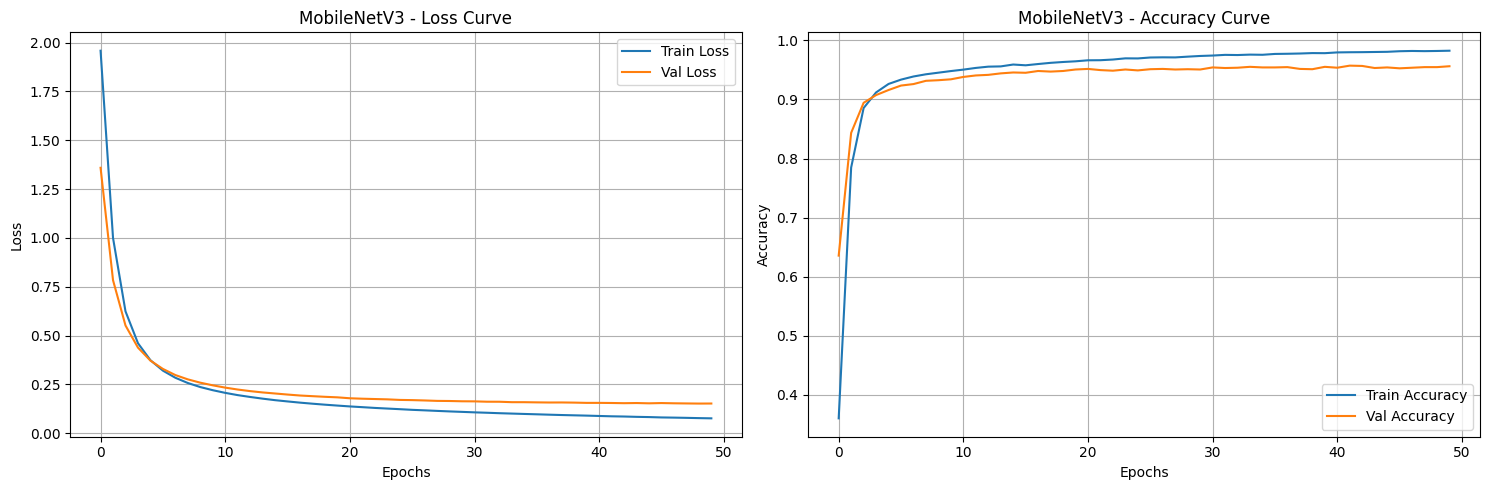

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9662 - loss: 0.1116 - mAP: 0.9943
✅ Test Accuracy: 96.52%
✅ Test mAP:      0.9936


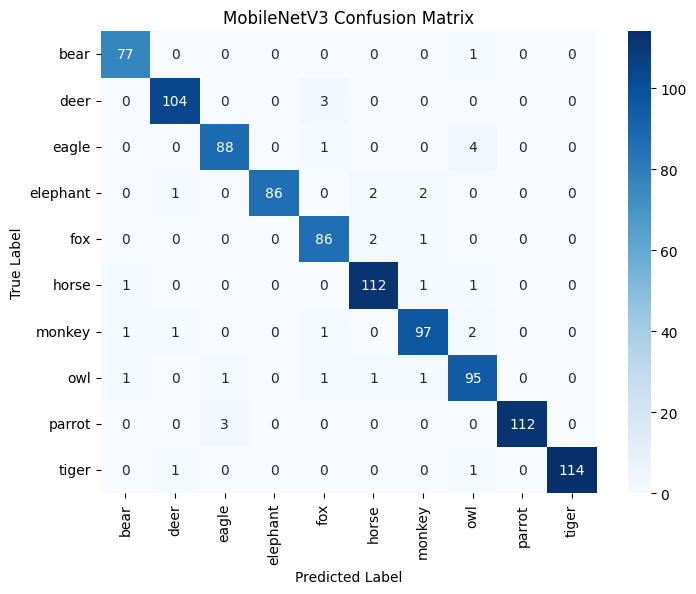


📊 EVALUATING: ResNet50


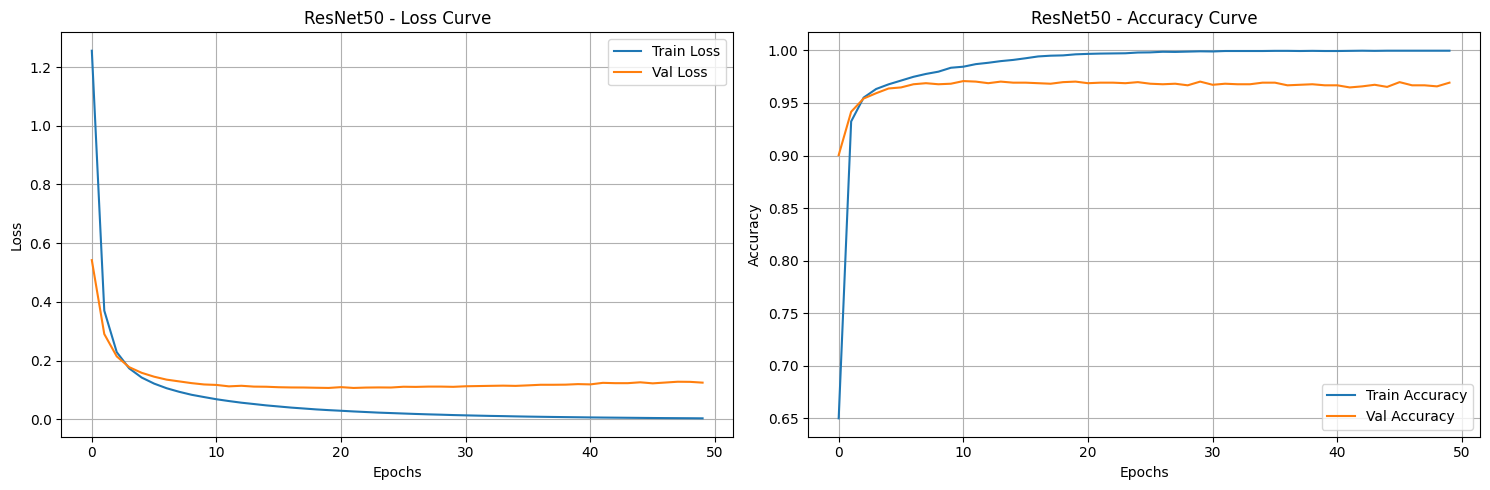

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9813 - loss: 0.0836 - mAP: 0.9929
✅ Test Accuracy: 97.91%
✅ Test mAP:      0.9941


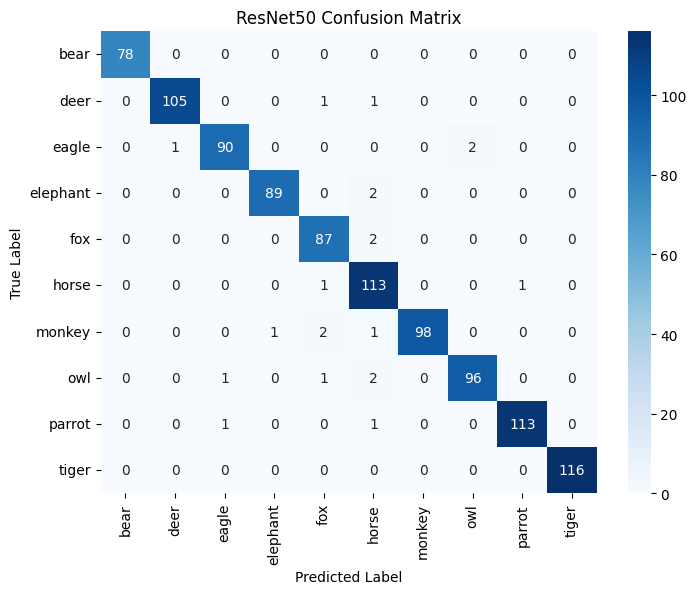


📊 EVALUATING: DenseNet121


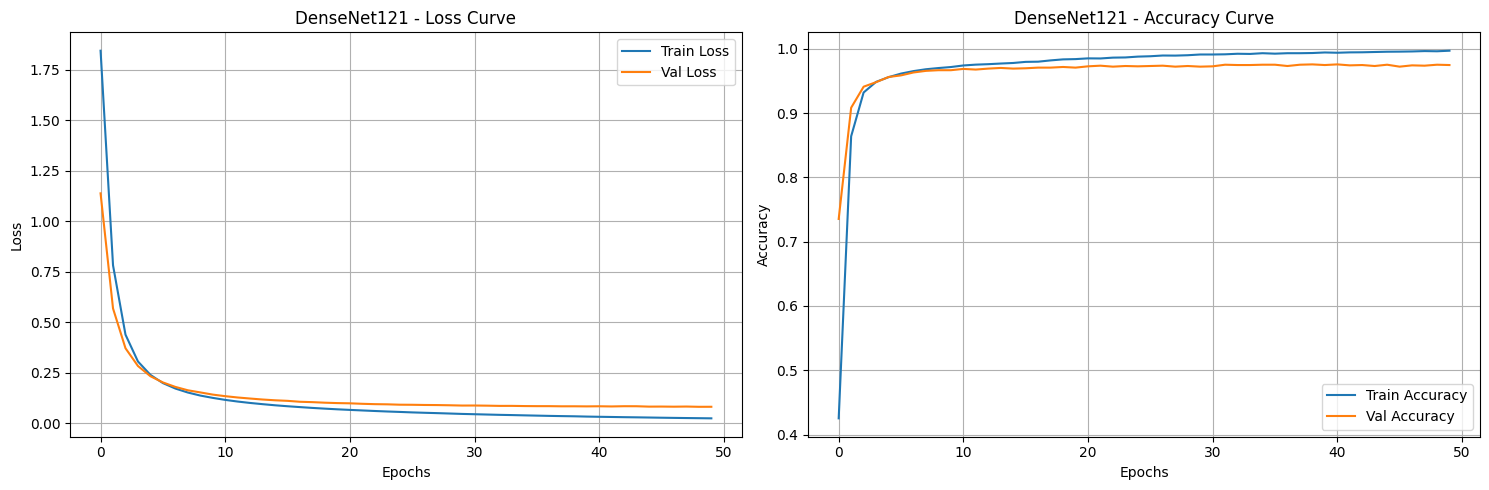

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9765 - loss: 0.0776 - mAP: 0.9970
✅ Test Accuracy: 97.81%
✅ Test mAP:      0.9974


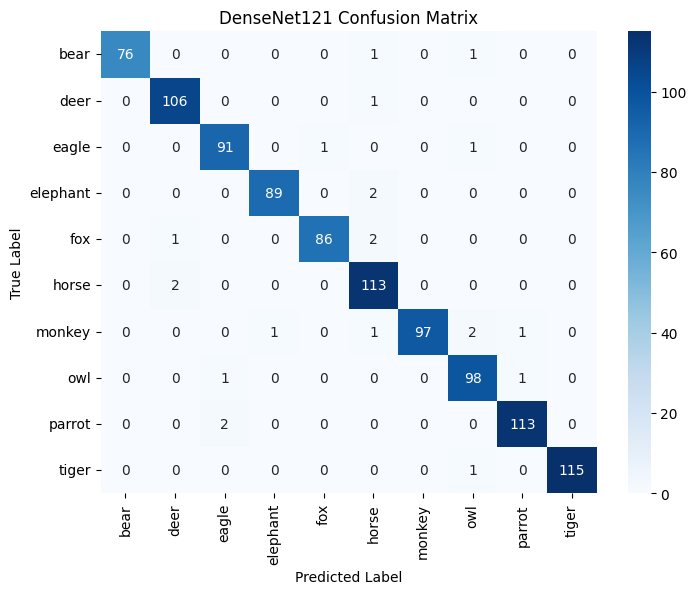

In [ ]:
# --- FINAL EVALUATION & PLOTTING ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Reusable Function to Plot Loss AND Accuracy
def evaluate_model(model, generator, history, name):
    print(f"\n{'='*40}")
    print(f"📊 EVALUATING: {name}")
    print(f"{'='*40}")

    # --- 1. PLOT GRAPHS (Loss & Accuracy) ---
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Loss (Left Graph)
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_title(f'{name} - Loss Curve')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Accuracy (Right Graph)
    axes[1].plot(history.history['accuracy'], label='Train Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[1].set_title(f'{name} - Accuracy Curve')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # --- 2. GET TEST METRICS ---
    # Check if model has mAP; if not, handle gracefully
    results = model.evaluate(generator, verbose=1)
    if len(results) == 3:
        loss, acc, map_score = results
        print(f"✅ Test Accuracy: {acc*100:.2f}%")
        print(f"✅ Test mAP:      {map_score:.4f}")
    else:
        loss, acc = results
        print(f"✅ Test Accuracy: {acc*100:.2f}%")

    # --- 3. CONFUSION MATRIX ---
    generator.reset() # Important: Reset generator to start
    predictions = model.predict(generator, verbose=0)
    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(generator.class_indices.keys()),
                yticklabels=list(generator.class_indices.keys()))
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# --- EXECUTE FOR ALL 3 MODELS ---

# 1. MobileNet
evaluate_model(model_mobilenet, test_gen_mobile, history_mobilenet, "MobileNetV3")

# 2. ResNet
evaluate_model(model_resnet, test_gen_resnet, history_resnet, "ResNet50")

# 3. DenseNet
evaluate_model(model_densenet, test_gen_dense, history_densenet, "DenseNet121")

# Conclusion
| Aspect | MobileNetv3 | ResNet 50 | DenseNet 121 |
| :--- | :--- | :--- | :--- |
| Trainable Parameters | 5770 | 20 490 | 10 250 |
| Validation Accuracy<br>(based on last epoch) | 0.9562 | 0.9693 | 0.9748 |
| Validation Mean Average Precision (mAP)<br>(based on the last epoch) | 0.9898 | 0.9897 | 0.9957 |
| Performance against test data | Test Accuracy: 0.9652<br> Test mAP: 0.9936 | Test Accuracy: 0.9791<br>Test mAP: 0.9941 | Test Accuracy: 0.9781<br>Test mAP: 0.9974 |
| Training Time | 11 minutes | 20 minutes | 21 minutes |

After evaluating three model (MobileNetV3, ResNet50, and DenseNet121) on the animal species dataset, <b>ResNet50</b> is selected as the best performance model for this classification task.

This conclusion is supported by the following critical analysis of the performance metrics:
<ol>
<li>Highest Test Accuracy</li>
ResNet50 achieved the highest Test Accuracy of 97.91%. ResNet50 outperforms DenseNet121 (97.81%) by a narrow margin and MobileNetV3 (96.52%) by a significant 1.4%. This indicates that ResNet’s deep residual architecture was the most effective at capturing the complex features required to distinguish between similar animal classes without overfitting.

---

<li>High Confidence and Reliability (mAP)</li>
ResNet50 achieved a Test mAP (Mean Average Precision) of 0.9941. While DenseNet121 achieved a slightly higher mAP (0.9974), the difference is negligible(< 0.003). ResNet50's high mAP confirms that its predictions are not only accurate but also highly confident, with a very low rate of false positives.

---

<li>Training Time</li>
ResNet50 required 20 minutes to train, compared to MobileNetV3’s 11 minutes. Although MobileNetV3 is nearly 2x faster, the trade-off for speed resulted in lower accuracy. The extra 9 minutes of training time is a negligible cost to pay for the superior accuracy (+1.4%) provided by ResNet50. Furthermore, ResNet50 trained slightly faster than DenseNet121 (20 mins vs. 21 mins), making it the more efficient choice among the high-accuracy models.

---

<li>Parameter</li>
The trainable parameters for ResNet50 (~20,490) were higher than the others. Despite having more trainable parameters, the model did not suffer from overfitting, as evidenced by the high Validation Accuracy (96.93%) and Test Accuracy (97.91%). This suggests the added complexity was necessary and effectively utilized to learn the fine-grained details of the dataset.

</ol>

---

<b>ResNet50</b> is chosen as the overall best model for this project. It delivers the peak accuracy required for a reliable wildlife classification system while maintaining a reasonable training time.
